# 1. Openfile and get structures & tensors

1. Import the file "Alnmr.json", switch the **dict of structure** to **structure**
2. Add oxidation state to each atom
3. switch **structure** back to **dict of structure**, save the file as "27Al_structure_tensor (oxidation specified).json"
4. reload the file, switch **dict of structure** back to **structure**

In [74]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from  pymatgen.core.structure import Structure as ST
from pymatgen.core.sites import Site
from pymatgen.analysis.nmr import ChemicalShielding
from pymatgen.io import ase
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.analysis.local_env import NearNeighbors
from pymatgen.analysis.nmr import ElectricFieldGradient
import copy
import itertools
import statistics

In [75]:
import json
import plotly
#import plotly.plotly as py
import plotly.graph_objs as go
#import dscribe
import numpy as np
import pandas as pd
from  more_itertools import unique_everseen
from scipy import sparse
import matplotlib.pyplot as plt
import random
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
import statistics
from tqdm import tqdm
from matminer.featurizers.base import MultipleFeaturizer
from pymatgen.analysis.local_env import VoronoiNN
from matminer.featurizers.site import AverageBondLength
from matminer.featurizers.site import AverageBondAngle
from matminer.featurizers.site import SiteElementalProperty
from matminer.featurizers.site import VoronoiFingerprint
from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.site import BondOrientationalParameter
from matminer.featurizers.site import ChemicalSRO
from matminer.featurizers.site import EwaldSiteEnergy
from matminer.featurizers.site import ChemEnvSiteFingerprint
from matminer.featurizers.site import CoordinationNumber
from matminer.featurizers.site import AGNIFingerprints
from matminer.featurizers.site import GeneralizedRadialDistributionFunction
from matminer.featurizers.site import AngularFourierSeries
from matminer.featurizers.site import GaussianSymmFunc

In [76]:
with open('Alnmr.json','r') as file:
    data=json.load(file)
    print("length of file is {}".format(len(data)))

length of file is 3479


In [10]:
def get_structure_NMR (data):
    """
    CONVERT THE TYPE OF STRUCTURE INFO FROM "DICT" TO "STRUCTURE"
    CALCULATE NMR PARAMS OF THE ATOM OF INTEREST FROM RAW TENSOR 
    """
    compounds=[]
#     c_index=0
    for compound in tqdm(data,position=0):
        if compound == {}:
            continue
        tensors=[]
        site_index=0
        structure=ST.from_dict(compound['structure'])
        structure.add_oxidation_state_by_guess() 
        for site in structure.sites:
            lengthes=[]
            if site.species_string[:2]=='Al':
                #add nmr tensor informations
                cs_origin=compound['cs'][site_index]
                cs_symmetric=0.5*(cs_origin+np.transpose(cs_origin))
                cs=ChemicalShielding(cs_symmetric)
                efg_origin=compound['efg'][site_index]
                efg=ElectricFieldGradient(efg_origin)
                tensor={'diso':cs.haeberlen_values[0],
                        'csa':cs.haeberlen_values[1],
                        'csa_reduced':cs.haeberlen_values[2],
                        'etacs':cs.haeberlen_values[3],
                        'etaQ':efg.asymmetry,
                        'CQ':efg.coupling_constant(specie='Al'),
                        'site_index':site_index}
                tensors.append(tensor)
            site_index+=1
        compounds.append({"structure":structure,'tensors':tensors})
#         print(c_index)
#         c_index+=1
    return(compounds)

In [11]:
#get all the diso (or other nmr parameters)
def get_nmr_param(structures,key,nmr_param='diso'):
#key = type of site that we are dealing with, exp: "4coord_tensor"
    nmr_param_list=[]
    for compound in structures:
        for tensor in compound[key]:
            nmr_param_list.append(tensor[nmr_param])
#     pd.DataFrame(nmr_param_list).to_csv("29Si_{}_All.csv".format(nmr_param))
    return(nmr_param_list)

#get the outlier of diso
def is_outlier(compound_list,key,maximum,minimum,nmr_param='diso'):
#key = type of site that we are dealing with, exp: "4coord_tensor"
    outlier_list=[]
    for compound in compound_list:
        for tensor in compound[key]:
            if tensor[nmr_param]>maximum or tensor[nmr_param]<minimum:
                outlier_list.append(compound)
                break
    return(outlier_list)

In [12]:
def struc_to_cif(structure):
    structure.to(filename='try.cif',fmt='cif')

In [13]:
structures_tensors=get_structure_NMR(data)

 35%|███▍      | 1216/3479 [2:57:08<55:24,  1.47s/it]  /home/he/anaconda3/lib/python3.7/site-packages/pymatgen/analysis/nmr.py:180: RuntimeWarning:

invalid value encountered in double_scalars

100%|██████████| 3479/3479 [3:03:03<00:00,  3.16s/it]


### ********Save and reload here********

In [14]:
#Save
for compound in structures_tensors:
    compound['structure'] = compound['structure'].as_dict()
with open('27Al_structure_tensor (oxidation specified).json','w') as file:
    json.dump(structures_tensors,file)

In [15]:
#Reload
with open ('27Al_structure_tensor (oxidation specified).json','r') as file:
    structures_tensors = json.load(file)
for compound in structures_tensors:
    compound['structure'] = ST.from_dict(compound['structure'])

# 2. Get first shell coordination number, and sort the dataset beased on it

Output of this section: **first_shell_dict_neat**

In [16]:
def from_dict_to_csv(dictionary,filename):
    result=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in dictionary.items()]))
    result.to_csv(filename)
    return(result)

In [17]:
def get_Ncoord_Si (data,N,coord_atom="O",consider_coord_atom=True):
    crystalnn=CrystalNN()
    data_copy=copy.deepcopy(data)
    if consider_coord_atom==True:
        name='{}coord_{}_tensor'.format(N,coord_atom)
    else:
        name='{}coord_tensor'.format(N)
        
    for compound in tqdm(data_copy):
        tensor_Ncoord=[]
        for Si_tensor in compound['tensors']:
            cn=crystalnn.get_cn(compound['structure'],int(Si_tensor['site_index']))
            nn_info=crystalnn.get_nn_info(compound['structure'],int(Si_tensor['site_index']))
            if cn==N:
                Si_tensor['first_shell_atoms']=nn_info
                if consider_coord_atom==True:#if true, then consider only the sites coordinated to the "coord_atom".
                    count=0
                    for atom in nn_info:
                        if atom['site'].species_string == coord_atom:
                            count+=1
                    if count==N:
                        tensor_Ncoord.append(Si_tensor)
                else:
                    tensor_Ncoord.append(Si_tensor)
        compound[name]=tensor_Ncoord
    return(data_copy)

def group_sites(compounds_list, key, atom_type='first_shell_atoms'):
#key = type of site that we are dealing with, exp: "4coord_tensor"
#atom_type = first or second shell atoms
    #get a list of all the posible combinitions of second_shell_atoms
    site_list=[]
    for compound in compounds_list:
        for site in compound[key]:
            site_shortlist=[]
            for atom in site[atom_type]:
                site_shortlist.append(atom['site'].species_string)
            site_shortlist.sort()
            site[atom_type+'_shortlist']=site_shortlist
            site_list.append(site_shortlist)

    #get poportion of each type of second_shell_atom_combination
    site_list.sort()
    for key, group in itertools.groupby(site_list):
        group_list=list(group)
        print(key,"*",len(group_list),"*",round(len(group_list)/len(site_list),3))

    #remove the duplicates of second_site_list==second_shell_4_atoms_combinations
    site_combinations=[k for k,g in itertools.groupby(site_list)]
    site_combinations
    
    return(site_combinations)

def group_sites_nmr(structs,sites_combination,nmr_string,key,atom_type='first_shell_atoms'):
    #key = type of site that we are dealing with, exp: "4coord_tensor"
    site_group={}
    for sites_string in sites_combination:
        sites_string=str(sites_string)
        for compound in structs:
            for site in compound[key]:
                if str(site[atom_type+'_shortlist'])==sites_string:
                    site_group.setdefault(sites_string,[]).append(site[nmr_string])
    return(site_group)

def Ncoord_getStructures_group_outputNMR(structures_tensors,N):
    N_coord_structures=get_Ncoord_Si(structures_tensors,N,consider_coord_atom=False)
    N_coord_first_shell_grouped=group_sites(N_coord_structures,'{}coord_tensor'.format(N))
    for nmr_string in ['diso','csa_reduced','etacs','CQ','etaQ']:
        site_group=group_sites_nmr(N_coord_structures,N_coord_first_shell_grouped,nmr_string,'{}coord_tensor'.format(N))
        from_dict_to_csv(site_group,"{}_first_second_shell_atoms_{}.csv".format(N,nmr_string))
    return(N_coord_structures)


In [19]:
first_shell_dict={}
for N in tqdm(range(16)):
    first_shell_dict['{}coord_struct'.format(str(N))] = Ncoord_getStructures_group_outputNMR(structures_tensors[:],N)

  0%|          | 0/3471 [00:00<?, ?it/s]/home/he/anaconda3/lib/python3.7/site-packages/pymatgen/analysis/local_env.py:3347: UserWarning:

CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.


  6%|▋         | 1/16 [12:17<3:04:25, 737.69s/it]

[] * 26 * 1.0



 12%|█▎        | 2/16 [24:42<2:52:35, 739.68s/it]

['Au0+'] * 1 * 0.015
['Co0+'] * 3 * 0.045
['Cu0+'] * 3 * 0.045
['F-'] * 2 * 0.03
['Fe0+'] * 4 * 0.06
['H0+'] * 2 * 0.03
['Ni0+'] * 36 * 0.537
['Ru0+'] * 4 * 0.06
['W0+'] * 12 * 0.179



100%|██████████| 3471/3471 [12:04<00:00,  1.33it/s]


['Au0+', 'Au0+'] * 6 * 0.008
['Au0+', 'Li0+'] * 2 * 0.003
['Au0+', 'Tc0+'] * 2 * 0.003
['B0+', 'B0+'] * 3 * 0.004
['B3-', 'B3-'] * 1 * 0.001
['Ba0+', 'Ba0+'] * 1 * 0.001
['C0+', 'C0+'] * 1 * 0.001
['C0+', 'O0+'] * 2 * 0.003
['C4-', 'C4-'] * 9 * 0.012
['Ca0+', 'Ca0+'] * 8 * 0.011
['Cl0+', 'Cl0+'] * 1 * 0.001
['Co0+', 'Co0+'] * 193 * 0.258
['Co0+', 'Li0+'] * 2 * 0.003
['Co0+', 'Rh0+'] * 2 * 0.003
['Co0+', 'Tc0+'] * 2 * 0.003
['Cr0+', 'Cr0+'] * 8 * 0.011
['Cr0+', 'Fe0+'] * 2 * 0.003
['Cr0+', 'Ir0+'] * 2 * 0.003
['Cr0+', 'Tc0+'] * 2 * 0.003
['Cu0+', 'Cu0+'] * 18 * 0.024
['Cu0+', 'Ni0+'] * 2 * 0.003
['Cu0+', 'Pd0+'] * 2 * 0.003
['Cu0+', 'Tc0+'] * 2 * 0.003
['Er0+', 'Er0+'] * 4 * 0.005
['F-', 'F-'] * 1 * 0.001
['Fe0+', 'Fe0+'] * 29 * 0.039
['Fe0+', 'Pt0+'] * 2 * 0.003
['Fe0+', 'Tc0+'] * 2 * 0.003
['Ga0+', 'Ga0+'] * 7 * 0.009
['H-', 'H-'] * 2 * 0.003
['Hf0+', 'Hf0+'] * 2 * 0.003
['Hg0+', 'Hg0+'] * 1 * 0.001
['Ir0+', 'Ir0+'] * 28 * 0.037
['Ir0+', 'Mn0+'] * 2 * 0.003
['Ir0+', 'Tc0+'] * 2 * 0.00

 25%|██▌       | 4/16 [49:04<2:27:05, 735.47s/it]

['As3-', 'As3-', 'As3-'] * 12 * 0.015
['Au0+', 'Au0+', 'Au0+'] * 154 * 0.188
['C0+', 'C0+', 'C0+'] * 8 * 0.01
['C4-', 'C4-', 'C4-'] * 37 * 0.045
['Cl0+', 'Cl0+', 'Cl0+'] * 1 * 0.001
['Co0+', 'Co0+', 'Co0+'] * 102 * 0.124
['Co0+', 'Co0+', 'Cu0+'] * 6 * 0.007
['Cu0+', 'Cu0+', 'Cu0+'] * 4 * 0.005
['F-', 'F-', 'F-'] * 1 * 0.001
['Fe0+', 'Fe0+', 'Fe0+'] * 4 * 0.005
['Fe0+', 'Fe0+', 'Si0+'] * 8 * 0.01
['Ge0+', 'Ge0+', 'Ge0+'] * 16 * 0.019
['H+', 'N3-', 'N3-'] * 8 * 0.01
['Ir0+', 'Ir0+', 'Ir0+'] * 24 * 0.029
['Mn0+', 'Ni0+', 'Ni0+'] * 2 * 0.002
['Mo0+', 'Mo0+', 'Mo0+'] * 16 * 0.019
['N2.6-', 'N2.6-', 'N2.6-'] * 2 * 0.002
['N2.6-', 'N2.6-', 'O2-'] * 2 * 0.002
['N3-', 'N3-', 'N3-'] * 2 * 0.002
['N3-', 'N3-', 'O2-'] * 9 * 0.011
['N3-', 'O2-', 'O2-'] * 4 * 0.005
['Ni0+', 'Ni0+', 'Ni0+'] * 162 * 0.197
['O2-', 'O2-', 'O2-'] * 40 * 0.049
['Os0+', 'Os0+', 'Os0+'] * 16 * 0.019
['P3-', 'P3-', 'P3-'] * 24 * 0.029
['Pd0+', 'Pd0+', 'Pd0+'] * 20 * 0.024
['Pt0+', 'Pt0+', 'Pt0+'] * 40 * 0.049
['Rh0+', 'Rh0+'


100%|██████████| 3471/3471 [12:38<00:00,  1.30it/s]


['Al0+', 'Al0+', 'Os0+', 'Ru0+'] * 2 * 0.0
['Al0+', 'Mg0+', 'Mg0+', 'Mg0+'] * 8 * 0.001
['Al0+', 'Te0+', 'Te0+', 'Te0+'] * 10 * 0.002
['As2.66666667-', 'As2.66666667-', 'As2.66666667-', 'As2.66666667-'] * 16 * 0.003
['As3-', 'As3-', 'As3-', 'As3-'] * 68 * 0.011
['Au0+', 'Au0+', 'Au0+', 'Au0+'] * 33 * 0.005
['Au0+', 'Au0+', 'Au0+', 'Ge0+'] * 6 * 0.001
['Au0+', 'Au0+', 'Au0+', 'Si0+'] * 10 * 0.002
['Au0+', 'Ge0+', 'Ge0+', 'Ge0+'] * 6 * 0.001
['Au0+', 'Si0+', 'Si0+', 'Si0+'] * 10 * 0.002
['B0+', 'B0+', 'B0+', 'B0+'] * 1 * 0.0
['Bi0+', 'Bi0+', 'Bi0+', 'Bi0+'] * 5 * 0.001
['Bi0+', 'Cl0+', 'Cl0+', 'Cl0+'] * 1 * 0.0
['Br-', 'Br-', 'Br-', 'Br-'] * 30 * 0.005
['Br-', 'Br-', 'Br-', 'S0+'] * 2 * 0.0
['Br0+', 'Br0+', 'Br0+', 'Br0+'] * 6 * 0.001
['Br0+', 'Br0+', 'Br0+', 'N-'] * 8 * 0.001
['Br0.14285714-', 'Br0.14285714-', 'Br0.14285714-', 'Br0.14285714-'] * 2 * 0.0
['C-', 'N3-', 'N3-', 'N3-'] * 2 * 0.0
['C-', 'N3-', 'N3-', 'O2-'] * 6 * 0.001
['C0+', 'C0+', 'C0+', 'C0+'] * 8 * 0.001
['C0+', 'C0+', '

100%|██████████| 3471/3471 [13:06<00:00,  1.15it/s]


['Au0+', 'Au0+', 'Au0+', 'Au0+', 'Au0+'] * 20 * 0.033
['C4-', 'C4-', 'C4-', 'N3-', 'N3-'] * 4 * 0.007
['C4-', 'C4-', 'N3-', 'N3-', 'N3-'] * 6 * 0.01
['Co0+', 'Co0+', 'Co0+', 'Cu0+', 'Cu0+'] * 4 * 0.007
['Cu0+', 'Cu0+', 'Cu0+', 'Cu0+', 'Cu0+'] * 2 * 0.003
['F-', 'F-', 'F-', 'F-', 'F-'] * 3 * 0.005
['F-', 'F-', 'O2-', 'O2-', 'O2-'] * 4 * 0.007
['F-', 'O2-', 'O2-', 'O2-', 'O2-'] * 1 * 0.002
['Fe0+', 'Si0+', 'Si0+', 'Si0+', 'Si0+'] * 6 * 0.01
['Ge0+', 'Ge0+', 'Ge0+', 'Ge0+', 'Ge0+'] * 6 * 0.01
['H+', 'O2-', 'O2-', 'O2-', 'O2-'] * 2 * 0.003
['Li0+', 'Li0+', 'Li0+', 'Li0+', 'Li0+'] * 2 * 0.003
['N2.6-', 'N2.6-', 'N2.6-', 'N2.6-', 'O2-'] * 2 * 0.003
['N3-', 'N3-', 'N3-', 'N3-', 'O2-'] * 4 * 0.007
['N3-', 'N3-', 'N3-', 'O2-', 'O2-'] * 2 * 0.003
['N3-', 'N3-', 'O2-', 'O2-', 'O2-'] * 3 * 0.005
['N3-', 'O2-', 'O2-', 'O2-', 'O2-'] * 7 * 0.012
['Ni0+', 'Ni0+', 'Ni0+', 'Ni0+', 'Ni0+'] * 3 * 0.005
['Ni0+', 'Ni0+', 'Ni0+', 'Yb0+', 'Yb0+'] * 2 * 0.003
['O0+', 'O0+', 'O0+', 'O0+', 'O0+'] * 18 * 0.03
['O

100%|██████████| 3471/3471 [13:21<00:00,  1.52it/s]


['Al0+', 'Al0+', 'Al0+', 'Al0+', 'U0+', 'U0+'] * 4 * 0.001
['Al0+', 'Al0+', 'Np0+', 'Np0+', 'Np0+', 'Np0+'] * 2 * 0.0
['Al0+', 'Al0+', 'Pu0+', 'Pu0+', 'Pu0+', 'Pu0+'] * 2 * 0.0
['Al0+', 'Al0+', 'Sm0+', 'Sm0+', 'Sm0+', 'Sm0+'] * 4 * 0.001
['Al0+', 'Al0+', 'Tb0+', 'Tb0+', 'Tb0+', 'Tb0+'] * 2 * 0.0
['C3.2-', 'C3.2-', 'C3.2-', 'C3.2-', 'C3.2-', 'C3.2-'] * 6 * 0.001
['Ca0+', 'Ca0+', 'Ca0+', 'Si0+', 'Si0+', 'Si0+'] * 2 * 0.0
['Cl-', 'Cl-', 'Cl-', 'Cl-', 'Cl-', 'Cl-'] * 4 * 0.001
['Cl-', 'Cl-', 'N3-', 'N3-', 'N3-', 'N3-'] * 4 * 0.001
['Cl-', 'Cl-', 'O2-', 'O2-', 'O2-', 'O2-'] * 2 * 0.0
['Cl-', 'N3-', 'N3-', 'N3-', 'N3-', 'N3-'] * 4 * 0.001
['Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+'] * 1 * 0.0
['Cu0+', 'Cu0+', 'Cu0+', 'Cu0+', 'Cu0+', 'Cu0+'] * 11 * 0.002
['Cu0+', 'Cu0+', 'Ir0+', 'Ir0+', 'Ir0+', 'Ir0+'] * 4 * 0.001
['Dy0+', 'Dy0+', 'Dy0+', 'Dy0+', 'Si0+', 'Si0+'] * 1 * 0.0
['Er0+', 'Er0+', 'Er0+', 'Er0+', 'Si0+', 'Si0+'] * 1 * 0.0
['F-', 'F-', 'F-', 'F-', 'F-', 'F-'] * 469 * 0.103
['F-', '

 50%|█████     | 8/16 [1:41:38<1:43:40, 777.52s/it]

['Al0+', 'Co0+', 'Co0+', 'Th0+', 'Th0+', 'Th0+', 'Th0+'] * 2 * 0.056
['H0.64285714+', 'H0.64285714+', 'H0.64285714+', 'H0.64285714+', 'H0.64285714+', 'H0.64285714+', 'N3-'] * 8 * 0.222
['O2-', 'O2-', 'O2-', 'O2-', 'O2-', 'O2-', 'O2-'] * 18 * 0.5
['Pt0+', 'Pt0+', 'Pt0+', 'Pt0+', 'Pt0+', 'Pt0+', 'Pt0+'] * 8 * 0.222



100%|██████████| 3471/3471 [12:20<00:00,  1.51it/s]


['Ag0+', 'Ag0+', 'Ag0+', 'Ag0+', 'Ag0+', 'Ag0+', 'Ag0+', 'Ag0+'] * 11 * 0.029
['Ag0+', 'Ag0+', 'Ag0+', 'Ag0+', 'B0+', 'B0+', 'B0+', 'B0+'] * 1 * 0.003
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Fe0+', 'Fe0+'] * 2 * 0.005
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'U0+', 'U0+'] * 8 * 0.021
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+', 'Mn0+', 'Mn0+'] * 2 * 0.005
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ba0+', 'Ba0+', 'Ba0+', 'Ba0+'] * 8 * 0.021
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ce0+', 'Ce0+', 'Ce0+', 'Ce0+'] * 1 * 0.003
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Sr0+', 'Sr0+', 'Sr0+', 'Sr0+'] * 2 * 0.005
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Yb0+', 'Yb0+', 'Yb0+', 'Yb0+'] * 1 * 0.003
['Al0+', 'Al0+', 'Al0+', 'Sr0+', 'Sr0+', 'Sr0+', 'Sr0+', 'Sr0+'] * 6 * 0.016
['Al0+', 'Al0+', 'Al0+', 'Tc0+', 'Tc0+', 'Tc0+', 'Tc0+', 'Tc0+'] * 2 * 0.005
['Al0+', 'Al0+', 'Ba0+', 'Ba0+', 'Ba0+', 'Ba0+', 'Ba0+', 'Ba0+'] * 4 * 0.011
['Al0+', 'Al0+', 'Co0+', 'Co0+', 'Si0+', 'Si0+', 'Si0+', 'Si0+'] * 3 * 0.008
['Al

100%|██████████| 3471/3471 [12:40<00:00,  1.51it/s]


['Ag0+', 'Ag0+', 'Ag0+', 'Ag0+', 'Ag0+', 'Ag0+', 'La0+', 'La0+', 'La0+'] * 2 * 0.007
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ba0+', 'Ba0+', 'Ba0+', 'Ba0+'] * 2 * 0.007
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ca0+', 'Ca0+', 'Ca0+', 'Ca0+'] * 2 * 0.007
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ca0+', 'Ca0+', 'Co0+', 'Co0+'] * 4 * 0.013
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ce0+', 'Ce0+', 'Ce0+', 'Ce0+'] * 2 * 0.007
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ce0+', 'Ce0+', 'Fe0+', 'Fe0+'] * 4 * 0.013
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Co0+', 'Co0+', 'Nd0+', 'Nd0+'] * 4 * 0.013
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Co0+', 'Co0+', 'Pr0+', 'Pr0+'] * 4 * 0.013
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'La0+', 'La0+', 'La0+', 'La0+'] * 10 * 0.033
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+'] * 2 * 0.007
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Nd0+', 'Nd0+', 'Nd0+', 'Nd0+'] * 2 * 0.007
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Pr0+', 'Pr0+', 'Pr0+',

100%|██████████| 3471/3471 [12:40<00:00,  1.51it/s]


['Ac0+', 'Ac0+', 'Ac0+', 'Ac0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+'] * 6 * 0.007
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+'] * 4 * 0.005
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'V0+'] * 4 * 0.005
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Fe0+', 'Fe0+'] * 2 * 0.002
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Fe0+', 'U0+'] * 16 * 0.019
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mo0+', 'Mo0+'] * 2 * 0.002
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Dy0+', 'Dy0+', 'Ti0+'] * 12 * 0.014
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+', 'Mn0+', 'Mn0+'] * 4 * 0.005
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ni0+', 'Ni0+', 'Ni0+'] * 2 * 0.002
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Np0+', 'Np0+', 'Np0+'] * 4 * 0.005
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Pu0+', 'Pu0+

100%|██████████| 3471/3471 [12:47<00:00,  1.50it/s]


['Ag0+', 'Al0+', 'Al0+', 'Mg0+', 'Mg0+', 'Mg0+', 'Mg0+', 'Mg0+', 'Mg0+', 'Mg0+', 'Mg0+'] * 3 * 0.006
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+'] * 12 * 0.025
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+'] * 4 * 0.008
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Re0+'] * 16 * 0.033
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Tc0+'] * 16 * 0.033
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'V0+'] * 12 * 0.025
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+', 'Cr0+'] * 2 * 0.004
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Fe0+', 'Fe0+'] * 4 * 0.008
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+', 'Mn0+'] * 16 * 0.033
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Re0+', 'Re0+'

100%|██████████| 3471/3471 [12:34<00:00,  1.47it/s]


['Ag0+', 'Ag0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ca0+', 'Ca0+', 'Ca0+', 'Ca0+', 'Ca0+'] * 6 * 0.004
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ca0+', 'Cr0+'] * 12 * 0.009
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+', 'Cr0+'] * 36 * 0.026
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+', 'Er0+'] * 24 * 0.017
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+', 'Mn0+'] * 12 * 0.009
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ti0+', 'Ti0+'] * 6 * 0.004
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'V0+', 'V0+'] * 18 * 0.013
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Ce0+', 'Ru0+', 'Ru0+'] * 4 * 0.003
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+', 'Cr0+', 'Cr0+'] * 3 * 0.002
['Al0+', 'Al0+',

 88%|████████▊ | 14/16 [2:57:55<25:28, 764.17s/it]

['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+', 'Cr0+'] * 4 * 0.053
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'V0+', 'V0+'] * 4 * 0.053
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+', 'Cr0+', 'Cr0+'] * 2 * 0.027
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+', 'Mn0+', 'Mn0+'] * 20 * 0.267
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+', 'Mn0+', 'Ni0+'] * 8 * 0.107
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Mn0+', 'Ni0+', 'Ni0+'] * 4 * 0.053
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Np0+', 'Np0+', 'Np0+'] * 2 * 0.027
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Pu0+', 'Pu0+', 'Pu0+'] * 2 * 0.027
['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 'Al0+', 


 94%|█████████▍| 15/16 [3:10:32<12:41, 761.84s/it]

['Al0+', 'Al0+', 'Al0+', 'Al0+', 'Cr0+', 'Cr0+', 'Cr0+', 'Cr0+', 'Cr0+', 'Cr0+', 'Cr0+', 'Cr0+', 'Cr0+', 'Cr0+'] * 1 * 0.091
['Al0+', 'Ce0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+', 'Co0+'] * 2 * 0.182
['B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+', 'B0+'] * 2 * 0.182
['Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Mo0+', 'Mo0+', 'Mo0+', 'Mo0+', 'Mo0+', 'Mo0+'] * 1 * 0.091
['Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'Fe0+', 'W0+', 'W0+', 'W0+', 'W0+', 'W0+', 'W0+'] * 1 * 0.091
['Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Re0+', 'Re0+', 'Re0+', 'Re0+', 'Re0+', 'Re0+'] * 1 * 0.091
['Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'Mn0+', 'W0+', 'W0+', 'W0+', 'W0+', 'W0+', 'W0+'] * 1 * 0.091
['Mo0+', 'Mo0+', 'Mo0+', 'Mo0+', 'Mo0+', 'Mo0+', 'Ti0+', 'Ti0+', 'Ti0+', 'Ti0+', 'Ti0+', 'Ti0+', 'Ti0+', 'Ti0+'] * 1 * 0.091
['Tc0+', 'Tc0+', 'Tc0+', '


100%|██████████| 16/16 [3:23:07<00:00, 759.98s/it]


In [20]:
# clean the duplicates
first_shell_dict_neat={}
for N in tqdm(range(15)):
    for compound in first_shell_dict['{}coord_struct'.format(str(N))]:
        if compound["{}coord_tensor".format(str(N))]!=[]:
            first_shell_dict_neat.setdefault(str(N),[]).append(compound)

100%|██████████| 15/15 [00:00<00:00, 248.33it/s]


### ********Save and reload here********

save

In [55]:
# define a subclass for json.dump method. if there exist numpy data types (int64 etc), switch them to regular type them comtinue json serialize.
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [57]:
# output data for machine learning
first_shell_dict_neat_copy = copy.deepcopy(first_shell_dict_neat)
for k, v in first_shell_dict_neat_copy.items():
    for compound in tqdm(v):
        #convert structure to dict
        compound['structure']=compound['structure'].as_dict()
        #get rid of site, to make it easier to transfer to json
        for tensor in compound['tensors']:
            if 'first_shell_atoms' in tensor.keys():
                for site in tensor['first_shell_atoms']:
                    site['site'] = Site.as_dict(site['site'])
#         for tensor_1 in compound["{}coord_tensor".format(k)]:
#             if 'first_shell_atoms' in tensor.keys():
#                 for site in tensor['first_shell_atoms']:
#                     site['site'] = site['site'].as_dict()
with open('27Al_first_shell_sorted.json', 'w') as json_file:
  json.dump(first_shell_dict_neat_copy, json_file, cls=NpEncoder)

100%|██████████| 9/9 [00:00<00:00, 610.68it/s]


Reload

In [61]:
# open the dataset from saved json file
with open('27Al_first_shell_sorted.json','r') as file:
    first_shell_dict_neat=json.load(file)

In [64]:
# get structure and site from dict
for k, v in first_shell_dict_neat.items():
    for compound in tqdm(v):
        #convert structure to dict
        compound['structure']=ST.from_dict(compound['structure'])
        #get rid of site, to make it easier to transfer to json
        for tensor in compound['tensors']:
            if 'first_shell_atoms' in tensor.keys():
                for site in tensor['first_shell_atoms']:
                    site['site'] = Site.from_dict(site['site'])
        for tensor_1 in compound["{}coord_tensor".format(k)]:
            for site in tensor_1['first_shell_atoms']:
                site['site'] = Site.from_dict(site['site'])

100%|██████████| 9/9 [00:00<00:00, 666.67it/s]


In [77]:
first_shell_dict_neat.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])

# 3. Analyse NMR params based on first shell coord

In [81]:
first_shell_dict_neat['3'][0]

{'structure': Structure Summary
 Lattice
     abc : 4.79018 9.01642 11.737638
  angles : 90.0 90.0 90.0
  volume : 506.9518102017713
       A : 4.79018 0.0 0.0
       B : 0.0 9.01642 0.0
       C : 0.0 0.0 11.737638
 PeriodicSite: Li+ (1.8248, 5.2919, 2.2303) [0.3809, 0.5869, 0.1900]
 PeriodicSite: Li+ (1.8248, 8.2327, 8.0991) [0.3809, 0.9131, 0.6900]
 PeriodicSite: Li+ (4.2199, 0.7837, 3.6386) [0.8809, 0.0869, 0.3100]
 PeriodicSite: Li+ (4.2199, 3.7245, 9.5074) [0.8809, 0.4131, 0.8100]
 PeriodicSite: Al3+ (1.7053, 0.3968, 1.6534) [0.3560, 0.0440, 0.1409]
 PeriodicSite: Al3+ (4.1004, 8.6196, 10.0842) [0.8560, 0.9560, 0.8591]
 PeriodicSite: Al3+ (1.7053, 4.1114, 7.5222) [0.3560, 0.4560, 0.6409]
 PeriodicSite: Al3+ (4.1004, 4.9050, 4.2154) [0.8560, 0.5440, 0.3591]
 PeriodicSite: Si4+ (3.6797, 7.9428, 1.3407) [0.7682, 0.8809, 0.1142]
 PeriodicSite: Si4+ (1.2846, 3.4346, 4.5281) [0.2682, 0.3809, 0.3858]
 PeriodicSite: Si4+ (1.2846, 1.0736, 10.3969) [0.2682, 0.1191, 0.8858]
 PeriodicSite: S

In [66]:
# put the nmr parameters together by nmr_string and coordinations  
first_shell_nmr_dict_large = {}
for nmr_string in ['diso','csa_reduced','etacs','CQ','etaQ']:
    first_shell_nmr_dict = {}
    for N in range(15):
        for compound in first_shell_dict_neat[str(N)]:
            for site in compound['{}coord_tensor'.format(str(N))]:
                first_shell_nmr_dict.setdefault(str(N),[]).append(site[nmr_string])
    first_shell_nmr_dict_large[nmr_string] = first_shell_nmr_dict

# output nmr_parameters to CSV file
for nmr_string in ['diso','csa_reduced','etacs','CQ','etaQ']:
    from_dict_to_csv(first_shell_nmr_dict_large[nmr_string],'27Al_first_shell_analysis_{}.csv'.format(nmr_string))

In [79]:
for k,v in first_shell_dict_neat.items():
    print(k,len(v))

0 18
1 26
2 214
3 158
4 1347
5 167
6 1148
7 7
8 275
9 87
10 189
11 64
12 399
13 12
14 9


## Put together the compounds with only O on the first shell of Al

**output**

1. first_shell_only_dict
2. 27Al_first_shell_analysis_O_diso.csv

In [82]:
#get only O coord structures
def get_certain_atom_coord(data,atom = 'O'):
    result={}
    for k,v in data.items():
        for compound in v:
            count=0
            for site in compound['{}coord_tensor'.format(k)]:
                first_shell_atoms_set = set()
                for atom in site['first_shell_atoms_shortlist']:
                    first_shell_atoms_set.add(atom[0])
                if first_shell_atoms_set=={'O'}:
                    count+=1
            if count==len(compound['{}coord_tensor'.format(k)]):
                result.setdefault(k,[]).append(compound)
    return(result)

In [83]:
# get the sturctures with pure O coords
first_shell_O_only_dict=get_certain_atom_coord(first_shell_dict_neat)

In [84]:
first_shell_O_only_dict.keys()

dict_keys(['2', '3', '4', '5', '6', '7', '8', '12'])

In [ ]:
def get_nmr_param_output(data,outputname):    
    # put the nmr parameters together by nmr_string and coordinations  
    first_shell_nmr_dict_large = {}
    for nmr_string in ['diso','csa_reduced','etacs','CQ','etaQ']:
        first_shell_nmr_dict = {}
        for N in data.keys():
            for compound in data[N]:
                for site in compound['{}coord_tensor'.format(N)]:
                    first_shell_nmr_dict.setdefault(N,[]).append(site[nmr_string])
        first_shell_nmr_dict_large[nmr_string] = first_shell_nmr_dict

    # output nmr_parameters to CSV file
    for nmr_string in ['diso','csa_reduced','etacs','CQ','etaQ']:
        from_dict_to_csv(first_shell_nmr_dict_large[nmr_string],(outputname+'_{}.csv').format(nmr_string))
    return(first_shell_nmr_dict_large)

In [ ]:
get_nmr_param_output(first_shell_O_only_dict,outputname='27Al_first_shell_analysis_O')

## Get Qn values for Al 

In [ ]:
def get_Q_values(compound):
    crystalnn=CrystalNN()
    for si_site in compound['4coord_tensor']:
        si_nn_info=crystalnn.get_nn_info(compound['structure'],si_site['site_index'])
        n=0
        for o_site in si_nn_info:
            o_nn_info=crystalnn.get_nn_info(compound['structure'],o_site['site_index'])
            c=0
            for site_around_o in o_nn_info:
                if site_around_o['site'].species_string=="Al":
                    c+=1
            if c==2:
                n+=1
        #print(n)
        si_site['Q_n']=n

In [ ]:
for compound in tqdm(first_shell_O_only_dict['4']):
    get_Q_values(compound)

In [ ]:
# Save Q'n values and corresponding NMR tensors as CSV
final_list=[]
for compound in first_shell_O_only_dict['4']:
    for site in compound['4coord_tensor']:
        final_list.append(site)
final_pd=pd.DataFrame(final_list,dtype=np.float64)

sort_by_Qn={}
for i in [0,1,2,3,4]:
    sort_by_Qn['{}'.format(i)]=[]
for i in final_pd.iterrows():
    if i[1].Q_n==0.0:
        sort_by_Qn['0'].append({'csa':i[1].csa,'diso':i[1].diso,'etacs':i[1].etacs,'CQ':i[1].CQ, 'etaQ':i[1].etaQ})
    if i[1].Q_n==1.0:
        sort_by_Qn['1'].append({'csa':i[1].csa,'diso':i[1].diso,'etacs':i[1].etacs,'CQ':i[1].CQ, 'etaQ':i[1].etaQ})
    if i[1].Q_n==2.0:
        sort_by_Qn['2'].append({'csa':i[1].csa,'diso':i[1].diso,'etacs':i[1].etacs,'CQ':i[1].CQ, 'etaQ':i[1].etaQ})
    if i[1].Q_n==3.0:
        sort_by_Qn['3'].append({'csa':i[1].csa,'diso':i[1].diso,'etacs':i[1].etacs,'CQ':i[1].CQ, 'etaQ':i[1].etaQ})
    if i[1].Q_n==4.0:
        sort_by_Qn['4'].append({'csa':i[1].csa,'diso':i[1].diso,'etacs':i[1].etacs,'CQ':i[1].CQ, 'etaQ':i[1].etaQ})

for key, value in sort_by_Qn.items():
    pd.DataFrame(value).to_csv('27Al_Q_{}_nmr_paramemters.csv'.format(key))

In [ ]:
for i in final_pd.iterrows():
    print(i[1].Q_n)

In [184]:
lis = [1,2,3,4]
m=[i+(10,) for i in itertools.combinations(lis,2)]
m[1]

(1, 3, 10)

# Structure featurize

In [97]:
# Turn complex numbers in an array into float 
def to_float(array):
    float_list=[]
    for number in array:
        float_list.append(float(number))
    return(float_list)

#check if all the elements in an iterable are zero, if so, return True
def all_zero(iterable):
    for item in iterable:
        if item!=0.0 and item!=False and item!=0:
            return False
    return True

# Input: a list of dict contain structure data. Output: a dict of features, tensors and error_index
def structure_featurizer (data,tensor_key="4coord_tensor",SimpFeature=True):
    """
    GET VARIAS KIND OF FEATURES (MATMINER FEATURES OR SIMPLE FEATURES) FROM A SET OF CRYSTAL STRUCTURES
    
    Variables:
    data: a set of compounds (a json like file containing sturcutre and tensor information) to transfer
    tensor_key: specify where to look at the tensor information of different sites
    SimpFeature: if True, calculate simple features (AVEbondlength, STDbondlength, AVEbondangle, STDbondangle of first and second shell neighbours)
    """

    from  pymatgen.core.structure import Structure as ST
    from pymatgen.analysis.nmr import ChemicalShielding
    from pymatgen.io import ase
    from pymatgen.core.structure import SiteCollection

    fingerprint_structure=[]
    tensors=[]
    err_index=[]
    struct_to_ase=ase.AseAtomsAdaptor()
    soap_nmr_list=[]
    soap_nmr=None
    simple_features=[]
    structure_list=[]
    SimpFeatureDict = {}
    # give every compound unique index
    ind=0
    for compound in data:
        compound['id']=ind
        ind+=1
    
    for compounds in tqdm(data,position=0):
        index_list=[]
        site_index=0
        structure=compounds['structure']
#         structure_ase=struct_to_ase.get_atoms(structure)
        structure_list.append(structure)
        
        #get all the index of tensors
        for tensor in compounds[tensor_key]:
            index_list.append(tensor['site_index'])
            
        #get simple features
        if SimpFeature == True:
            for tensor in compounds[tensor_key]:
                SiSite = tensor['site_index']
                BondLength=[]
                BondAngle=[]
                CoordSitesList = []
                
                #BondLength & BondAngle for the first shell
                for s in tensor['first_shell_atoms']:
                    CoordSite=s['site_index']
                    CoordSitesList.append(CoordSite)
                    BondLength.append(structure.get_distance(SiSite,CoordSite))
                    
                CoordSiteCombos = [i+(SiSite,) for i in itertools.combinations(CoordSitesList, 2)]
                for c in CoordSiteCombos:
                    BondAngle.append(structure.get_angle(i=c[0],j=c[2],k=c[1]))

                BondLengthSTD = statistics.stdev(BondLength)
                BondAngleSTD =  statistics.stdev(BondAngle)
                SimpFeatureDict.setdefault('BondLengthSTD',[]).append(BondLengthSTD)
                SimpFeatureDict.setdefault('BondAngleSTD',[]).append(BondAngleSTD)
                
#                 # bondlength for the second shell
#                 for s in tensor['second_shell_atoms']:
                    
        
#         #get SOAP
#         for atom in structure_ase:
#             if atom.symbol=='Si':
#                 soap_atom=soap.create(structure_ase,positions=[atom.index])
#                 soap_nmr_list.append(soap_atom)
#                 soap_nmr=sparse.vstack(soap_nmr_list)

        #get features (matminer)
        r=3
        for site in structure.sites:
            lengthes=[]
            if site_index in index_list:
                
                #featurize the structure of Si site#
                
                #matminer
                fingerprint=feat.featurize(structure,site_index)
                for num in range(len(fingerprint)):
                    fingerprint[num]=round(fingerprint[num],5)
                fingerprint_dict=dict(zip(labels,fingerprint))
                fingerprint_dict['abc']=site.coords
                fingerprint_dict['compounds_id']=compounds['id']
                fingerprint_dict['site_index']=site_index
                fingerprint_structure.append(fingerprint_dict) 
                
                #add nmr tensor informations
                for tensor in compounds[tensor_key]:
                    if tensor['site_index']==site_index:
                        tensors.append(tensor)
                
            site_index+=1                   

    #fingerprint_structure=list(unique_everseen(fingerprint_structure))
    return({'features':fingerprint_structure,'tensors':tensors,'err_index':err_index,
            'soap':soap_nmr,'simple_features':SimpFeatureDict,'structures':structure_list})

In [98]:
#separate_tensor_based_on_local_structure_types
def sep_tensor_chemenv(output,relavent_keys):
    #relavent_keys:for each coord_num, get the relavent keys in chemenv: ChemEnvSiteFingerprint_features
    chemenv_dict={}
    for feature, tensor in zip(output['features'],output['tensors']):
        maximum=0
        maximum_name=str()
        for local_site in relavent_keys:
            if feature[local_site]>maximum:
                maximum=feature[local_site]
                maximum_name=local_site
        tensor['compound_id']=feature['compounds_id']
        chemenv_dict.setdefault(maximum_name,[]).append(tensor)   
    return(chemenv_dict)

In [99]:
# Make a multiple featurizer #
feat= MultipleFeaturizer([
        #ChemEnvSiteFingerprint.from_preset('multi_weights'),
        #GeneralizedRadialDistributionFunction.from_preset('gaussian',width=0.5,spacing=0.5,cutoff=10),
        #GaussianSymmFunc(cutoff=6.5,etas_g2=[0.05,4,10,40,80],zetas_g4=[1,4],etas_g4=[0.005],gammas_g4=[+1,-1]),
        #AngularFourierSeries.from_preset('histogram'),
        #AGNIFingerprints(directions=[x],cutoff=5),
        AverageBondLength(VoronoiNN()),
        AverageBondAngle(VoronoiNN()),
        #VoronoiFingerprint(),
        #BondOrientationalParameter(),
        #CoordinationNumber.from_preset('VoronoiNN'),
])
labels=feat.feature_labels()

In [100]:
ChemEnvSiteFingerprint_features={'1':['S:1'],
                                '2':['L:2', 'A:2'],
                                '3':['TL:3', 'TY:3', 'TS:3'],
                                '4':['T:4', 'S:4', 'SY:4', 'SS:4'],
                                '5':['PP:5', 'S:5', 'T:5'],
                                '6':['O:6', 'T:6', 'PP:6'],
                                '7':['ST:7', 'ET:7', 'FO:7'],
                                '8':['C:8', 'SA:8', 'SBT:8', 'TBT:8', 'DD:8', 'DDPN:8', 'HB:8', 'BO_1:8', 'BO_2:8', 'BO_3:8'],
                                '9':['TC:9', 'TT_1:9', 'TT_2:9', 'TT_3:9', 'HD:9', 'TI:9', 'SMA:9', 'SS:9', 'TO_1:9', 'TO_2:9', 'TO_3:9'],
                                '10':['PP:10', 'PA:10', 'SBSA:10', 'MI:10', 'S:10', 'H:10', 'BS_1:10', 'BS_2:10', 'TBSA:10'],
                                '11':['PCPA:11', 'H:11', 'SH:11', 'CO:11', 'DI:11'],
                                '12':[ 'I:12', 'PBP:12', 'TT:12', 'C:12', 'AC:12', 'SC:12', 'S:12', 'HP:12', 'HA:12']
                                }

In [ ]:
# Featurize the structures in the data set
output = {}
for N in ['3', '4', '5', '6']:
    feature_output = structure_featurizer(first_shell_O_only_dict[N],tensor_key='{}coord_tensor'.format(N))
    output.setdefault(N,[]).append(feature_output)

In [ ]:
chemenv_dict = {}
for N in [ '3', '4', '5', '6']:
    output_dict = sep_tensor_chemenv(output[N][0],ChemEnvSiteFingerprint_features[N])
    chemenv_dict.update(output_dict)

In [ ]:
struc_to_cif(first_shell_O_only_dict['4'][76]['structure'])

In [ ]:
chemenv_dict['SS:4']

In [ ]:
chemenv_dict_nmr = {}
for k,v in chemenv_dict.items():
    for tensor in v:
        chemenv_dict_nmr.setdefault(k,[]).append(tensor['etaQ'])
from_dict_to_csv(chemenv_dict_nmr,'27Al_chemenv_sep.csv')

In [ ]:
struc_to_cif(first_shell_O_only_dict['4'][50]['structure'])

## MachineLearning

In [101]:
# Featurize the structures in the data set
MLoutput = {}
for N in ['4']:
    MLfeature_output = structure_featurizer(first_shell_dict_neat[N],tensor_key='{}coord_tensor'.format(N))
    MLoutput.setdefault(N,[]).append(MLfeature_output)

  1%|          | 14/1347 [00:04<05:42,  3.90it/s]/home/he/anaconda3/lib/python3.7/site-packages/matminer/featurizers/site.py:2130: RuntimeWarning:

invalid value encountered in arccos

 49%|████▉     | 658/1347 [06:12<08:02,  1.43it/s]/home/he/anaconda3/lib/python3.7/site-packages/pymatgen/util/coord.py:343: RuntimeWarning:

invalid value encountered in double_scalars

100%|██████████| 1347/1347 [11:09<00:00,  1.08it/s]


In [102]:
m = '4'
features_pd = pd.DataFrame(MLoutput[m][0]['features'])
tensors_pd = pd.DataFrame(MLoutput[m][0]['tensors'])
simple_features_pd = pd.DataFrame(MLoutput[m][0]['simple_features'])

In [101]:
# switch the lists in "first_shell_atoms_shortlist" to str, so that we can make a boolean mask
shortlist_str = []
for combo in tensors_pd['first_shell_atoms_shortlist']:
    shortlist_str.append(str(combo))
tensors_pd['first_shell_atoms_shortlist_str'] = shortlist_str

In [123]:
tensors_pd[tensors_pd['first_shell_atoms_shortlist_str'] == "['O', 'O', 'O', 'O']"]

,diso,csa,csa_reduced,etacs,etaQ,CQ,site_index,first_shell_atoms,first_shell_atoms_shortlist,first_shell_atoms_shortlist_str
0,273.046605,-41.473706,-27.649137,0.262944,0.514569,6.494513,2,[{'site': [-9.85798166e-01 -5.55458293e+00 2....,"[O, O, O, O]","['O', 'O', 'O', 'O']"
1,273.049711,-41.479747,-27.653164,0.263137,0.514604,6.494596,3,[{'site': [-5.77583017 -1.27921107 -2.88803389...,"[O, O, O, O]","['O', 'O', 'O', 'O']"
4,270.686021,6.524008,4.349339,0.285736,0.117030,-0.943131,8,[{'site': [-1.4058324 -0.29914186 -0.78017061...,"[O, O, O, O]","['O', 'O', 'O', 'O']"
5,270.684407,6.559077,4.372718,0.291346,0.117030,-0.943131,9,[{'site': [4.8717519 3.33086814 8.15425361] O...,"[O, O, O, O]","['O', 'O', 'O', 'O']"
6,268.772165,-2.247859,-1.498573,0.011931,0.000273,1.454526,5,[{'site': [0.92521928 1.78941197 4.04127678] O...,"[O, O, O, O]","['O', 'O', 'O', 'O']"
...,...,...,...,...,...,...,...,...,...,...
6304,278.077069,-69.934653,-46.623102,0.219005,0.251709,10.782764,22,[{'site': [ 4.09207882 6.73454197 -1.33337995...,"[O, O, O, O]","['O', 'O', 'O', 'O']"
6305,281.275856,-54.006160,-36.004107,0.445832,0.662881,8.058914,23,[{'site': [9.33022227 4.1255263 0.26950399] O...,"[O, O, O, O]","['O', 'O', 'O', 'O']"
6306,281.402480,-9.245501,-6.163667,0.364453,0.350955,4.140975,24,[{'site': [ 6.31514453 0.77841806 -2.95526452...,"[O, O, O, O]","['O', 'O', 'O', 'O']"
6307,279.905293,-67.303491,-44.868994,0.101273,0.138892,10.305626,25,[{'site': [ 6.7291834 3.45100091 -3.49118681...,"[O, O, O, O]","['O', 'O', 'O', 'O']"


In [169]:
FirstShellComboDict = {}
for combo in tensors_pd['first_shell_atoms_shortlist_str']:
    FirstShellComboDict.setdefault(combo,[]).append(combo)
for k, v in FirstShellComboDict.items():
    FirstShellComboDict[k] = len(v)
#     print(k,len(v))
FirstShellComboDictSorted = sorted(FirstShellComboDict.items(), key = lambda x : x[1], reverse=True)
print(FirstShellComboDictSorted)
FirstShellPopularCombos = [x[0] for x in FirstShellComboDictSorted[:10]]

[("['O', 'O', 'O', 'O']", 3871), ("['Cl', 'Cl', 'Cl', 'Cl']", 261), ("['N', 'N', 'N', 'N']", 231), ("['S', 'S', 'S', 'S']", 221), ("['N', 'N', 'N', 'O']", 128), ("['Pt', 'Pt', 'Pt', 'Pt']", 117), ("['Pd', 'Pd', 'Pd', 'Pd']", 104), ("['C', 'C', 'C', 'C']", 94), ("['Si', 'Si', 'Si', 'Si']", 88), ("['As', 'As', 'As', 'As']", 84), ("['Se', 'Se', 'Se', 'Se']", 83), ("['Te', 'Te', 'Te', 'Te']", 77), ("['Ge', 'Ge', 'Ge', 'Ge']", 74), ("['Co', 'Co', 'Co', 'Co']", 60), ("['Ni', 'Ni', 'Ni', 'Ni']", 55), ("['Sb', 'Sb', 'Sb', 'Sb']", 48), ("['I', 'I', 'I', 'I']", 44), ("['Mg', 'Mg', 'Mg', 'Mg']", 40), ("['Rh', 'Rh', 'Rh', 'Rh']", 38), ("['Br', 'Br', 'Br', 'Br']", 38), ("['N', 'O', 'O', 'O']", 33), ("['Au', 'Au', 'Au', 'Au']", 33), ("['Ru', 'Ru', 'Ru', 'Ru']", 31), ("['N', 'N', 'O', 'O']", 30), ("['Cu', 'Cu', 'Cu', 'Cu']", 29), ("['Cl', 'Cl', 'O', 'O']", 26), ("['Cl', 'Cl', 'Cl', 'N']", 24), ("['P', 'P', 'P', 'P']", 24), ("['Rh', 'Rh', 'Si', 'Si']", 16), ("['H', 'H', 'H', 'H']", 16), ("['Ir', 'Ir',

["['O', 'O', 'O', 'O']",
 "['Cl', 'Cl', 'Cl', 'Cl']",
 "['N', 'N', 'N', 'N']",
 "['S', 'S', 'S', 'S']",
 "['N', 'N', 'N', 'O']",
 "['Pt', 'Pt', 'Pt', 'Pt']",
 "['Pd', 'Pd', 'Pd', 'Pd']",
 "['C', 'C', 'C', 'C']",
 "['Si', 'Si', 'Si', 'Si']",
 "['As', 'As', 'As', 'As']"]

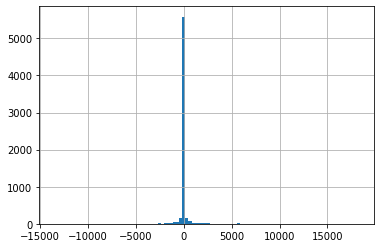

In [131]:
tensors_pd['csa'].hist(bins=100)

In [133]:
tensors_pd[(tensors_pd['diso']<200) | (tensors_pd['diso']>350)]

,diso,csa,csa_reduced,etacs,etaQ,CQ,site_index,first_shell_atoms,first_shell_atoms_shortlist,first_shell_atoms_shortlist_str
162,407.606896,198.395122,132.263414,0.366810,0.817117,-11.079200,1,"[{'site': [0. 4.264056 7.915248] Ir, 'im...","[Ir, Ir, Si, Si]","['Ir', 'Ir', 'Si', 'Si']"
163,408.409468,199.624312,133.082875,0.365162,0.817354,-11.087694,2,"[{'site': [4.264056 0. 7.915248] Ir, 'im...","[Ir, Ir, Si, Si]","['Ir', 'Ir', 'Si', 'Si']"
164,407.632856,198.376553,132.251035,0.366574,0.816741,-11.087339,3,"[{'site': [0. 4.264056 0. ] Ir, 'im...","[Ir, Ir, Si, Si]","['Ir', 'Ir', 'Si', 'Si']"
165,408.402058,199.655847,133.103898,0.365366,0.817566,-11.086985,4,"[{'site': [0. 0. 0.] Ir, 'image': [0, 0, 0], '...","[Ir, Ir, Si, Si]","['Ir', 'Ir', 'Si', 'Si']"
177,412.844102,209.177878,139.451919,0.179767,0.734747,-9.992043,1,"[{'site': [0. 4.241277 7.899553] Rh, 'im...","[Rh, Rh, Si, Si]","['Rh', 'Rh', 'Si', 'Si']"
...,...,...,...,...,...,...,...,...,...,...
6079,774.015930,-195.068991,-130.045994,0.426154,0.000034,10.769617,3,[{'site': [ 3.98293232 2.31531171 39.27749148...,"[C, C, C, C]","['C', 'C', 'C', 'C']"
6081,778.176028,-195.338454,-130.225636,0.389961,0.000034,10.769617,5,[{'site': [0.94881368 0.55155329 9.35667952] C...,"[C, C, C, C]","['C', 'C', 'C', 'C']"
6082,351.956717,302.006448,201.337632,0.067416,0.000501,-17.348136,6,[{'site': [ 4.24799268 0.54479529 41.89137052...,"[C, C, C, C]","['C', 'C', 'C', 'C']"
6091,766.883630,1332.811393,888.540929,0.060676,0.000030,12.966387,0,[{'site': [ 3.47034859 2.01379894 39.72918427...,"[C, C, C, N]","['C', 'C', 'C', 'N']"


In [135]:
# exclude all zero columns
excluded=[]
for column in features_pd.columns:
    if 'Voro_index_' in column or 'Symmetry_index_' in column or 'compounds_id' in column or 'site_index' in column or 'abc' in column:
        excluded.append(column)
        continue
    if all_zero(features_pd[column]):
        excluded.append(column)
print(excluded)
print(len(excluded))

['abc', 'compounds_id', 'site_index']
3


In [136]:
features_pd_drop = features_pd.drop(excluded,axis=1)

In [137]:
features_pd_drop['diso']=tensors_pd['diso']
features_pd_drop['csa']=tensors_pd['csa']
features_pd_drop['FirstShellComboStr']=tensors_pd['first_shell_atoms_shortlist_str']
features_pd_drop = pd.concat([features_pd_drop,simple_features_pd],axis=1)

In [141]:
features_pd_drop.columns

Index(['Average bond length', 'Average bond angle', 'diso', 'csa',
       'FirstShellComboStr', 'BondLengthSTD', 'BondAngleSTD'],
      dtype='object')

In [202]:
FeaturesPopularCombos = []
for row in features_pd_drop.iterrows():
    if row[1]['FirstShellComboStr'] in FirstShellPopularCombos:
        #print(type(row[1]))
        FeaturesPopularCombos.append(row[1])

In [203]:
FeaturesPopularCombos = pd.DataFrame(FeaturesPopularCombos)

/home/he/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



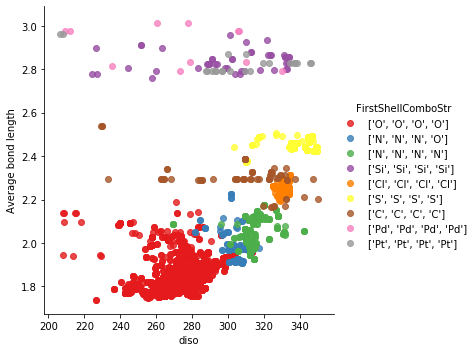

In [204]:
import seaborn as sns

sns.lmplot(x='diso', y='Average bond length', hue='FirstShellComboStr', 
           data=FeaturesPopularCombos[(FeaturesPopularCombos['diso']>200) & (features_pd_drop['diso']<350)],
           palette="Set1",
           fit_reg=False)

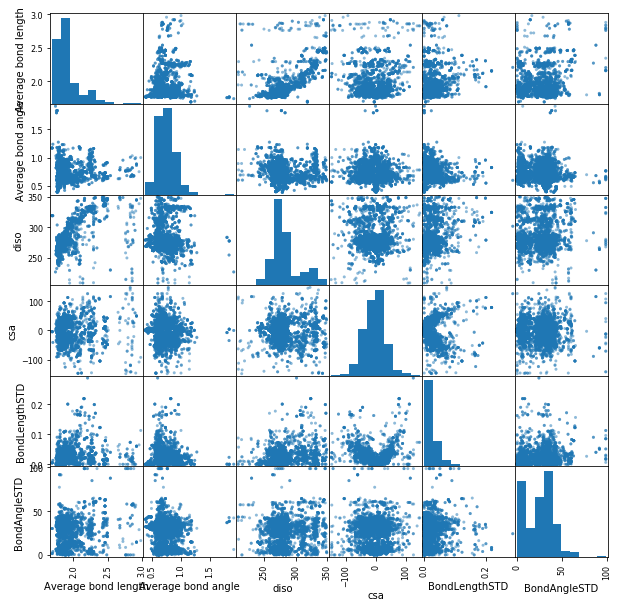

In [118]:
from pandas.plotting import scatter_matrix
features_pd_drop = features_pd_drop[(features_pd_drop['csa']>-150) & (features_pd_drop['csa']<150)]
# plt = scatter_matrix(features_pd_drop[(features_pd_drop['diso']>200) & (features_pd_drop['diso']<350)],figsize=(10,10))
plt = scatter_matrix(features_pd_drop,figsize=(10,10))

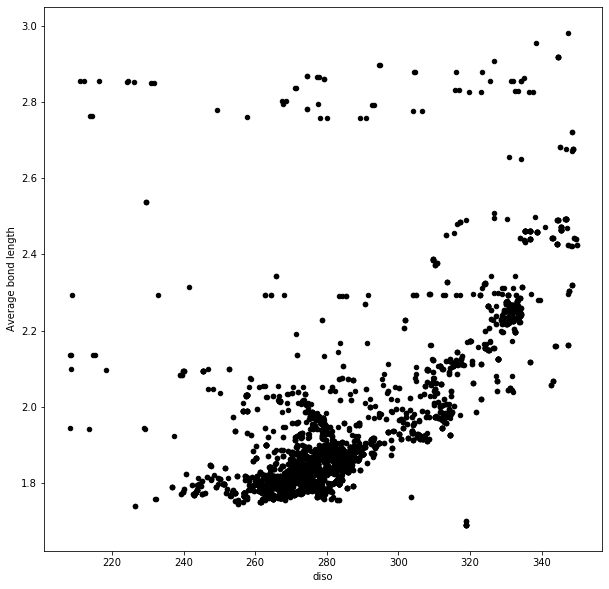

In [121]:
features_pd_drop = features_pd_drop[(features_pd_drop['diso']>200) & (features_pd_drop['diso']<350)]
plt = features_pd_drop.plot.scatter(x='diso',y='Average bond length',c='black',figsize=(10,10))

In [37]:
ConcPd = pd.concat([features_pd_drop['diso'],features_pd_drop.iloc[:,0:10]],axis=1)

from pandas.plotting import scatter_matrix
plt = scatter_matrix(ConcPd[(ConcPd['diso']>200) & (ConcPd['diso']<350)],figsize=(15,15))

KeyError: 'diso'

## analysis of the effect of second shell nuclei 

In [7]:
first_shell_dict_neat['4'][0]

{'structure': Structure Summary
 Lattice
     abc : 5.776062 7.4189934284508565 9.580064
  angles : 90.0 90.0 112.90941486799245
  volume : 378.14828913454596
       A : 0.0 0.0 -5.776062
       B : 0.0 -6.833794 2.888031
       C : -9.580064 0.0 0.0
 PeriodicSite: Ba (-4.7997, -6.6048, -2.8880) [0.9832, 0.9665, 0.5010]
 PeriodicSite: Ba (-0.0097, -0.2289, 0.0000) [0.0168, 0.0335, 0.0010]
 PeriodicSite: Al (-2.4417, -6.4707, -0.0000) [0.4734, 0.9469, 0.2549]
 PeriodicSite: Al (-7.2317, -0.3631, -2.8880) [0.5266, 0.0531, 0.7549]
 PeriodicSite: Al (-0.3737, -3.9254, 0.0000) [0.2872, 0.5744, 0.0390]
 PeriodicSite: Al (-5.1638, -2.9084, -2.8880) [0.7128, 0.4256, 0.5390]
 PeriodicSite: Si (-4.6572, -4.0683, -0.0000) [0.2977, 0.5953, 0.4861]
 PeriodicSite: Si (-9.4472, -2.7655, -2.8880) [0.7023, 0.4047, 0.9861]
 PeriodicSite: Si (-2.5053, -2.3678, -4.2988) [0.9175, 0.3465, 0.2615]
 PeriodicSite: Si (-2.5053, -2.3678, -1.4772) [0.4290, 0.3465, 0.2615]
 PeriodicSite: Si (-7.2953, -4.4660, 1.41

In [38]:
def get_2nd_shell_species(compound,N=4,coord_atom="O",consider_coord_atom=False):
    """
    GET SECOND SHELL SPECIES
    Based on tensor['first_shell_atoms'] and crystalNN
    """
    crystalnn=CrystalNN()
    
    if consider_coord_atom==True:
        name='{}coord_{}_tensor'.format(N,coord_atom)
    else:
        name='{}coord_tensor'.format(N)
    
    for si_site in compound[name]:
        si_nn_info=crystalnn.get_nn_info(compound['structure'],si_site['site_index'])
        list_2nd_shell=[]
        for o_site in si_nn_info:
            o_nn_info=crystalnn.get_nn_info(compound['structure'],o_site['site_index'])
            for site_around_o in o_nn_info:
                if site_around_o['site_index']!=si_site['site_index']:#not include the original Si site
                    list_2nd_shell.append(site_around_o)
        si_site['second_shell_atoms']=list_2nd_shell            

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
for compound in tqdm(first_shell_dict_neat['4']):
    get_2nd_shell_species(compound,N=4)


  4%|▍         | 60/1340 [00:28<11:22,  1.88it/s]

KeyboardInterrupt: 

In [12]:
first_shell_dict_neat['4'][100]

{'structure': Structure Summary
 Lattice
     abc : 5.037709899207477 7.699663407105859 8.696449457546796
  angles : 65.8310952312427 89.98024928397675 89.61977335460931
  volume : 307.74692677881023
       A : 5.037696 0.008514 0.008219
       B : 0.034098 7.033311 3.13308
       C : -0.011231 0.024032 8.696409
 PeriodicSite: Li (3.2420, 6.2581, 5.3310) [0.6382, 0.8880, 0.2925]
 PeriodicSite: Li (0.6679, 0.5716, 6.4846) [0.1337, 0.0787, 0.7172]
 PeriodicSite: Al (3.2363, 0.6586, 8.0808) [0.6438, 0.0898, 0.8962]
 PeriodicSite: Al (0.6434, 0.4616, 3.4935) [0.1281, 0.0642, 0.3785]
 PeriodicSite: Si (3.4778, 3.5950, 9.2837) [0.6889, 0.5073, 0.8841]
 PeriodicSite: Si (3.1881, 6.5526, 8.2813) [0.6279, 0.9288, 0.6171]
 PeriodicSite: Si (0.9523, 3.4729, 2.4345) [0.1859, 0.4932, 0.1021]
 PeriodicSite: Si (0.7589, 6.3294, 3.7360) [0.1448, 0.8994, 0.1054]
 PeriodicSite: O (4.9646, 3.8752, 9.9077) [0.9839, 0.5466, 0.9414]
 PeriodicSite: O (3.4980, 2.3517, 8.2618) [0.6940, 0.3307, 0.8302]
 Periodi

In [24]:
type(first_shell_dict_neat['4'][100]['4coord_tensor'][1]['second_shell_atoms'][1])

pymatgen.core.sites.PeriodicSite

In [129]:
import seaborn as sns

sns.lmplot(x='Value', y='Overall', hue='Position', 
           data=footballers.loc[footballers['Position'].isin(['ST', 'RW', 'LW'])], 
           fit_reg=False)